In [ ]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit, minimize, dual_annealing
from typing import List, Tuple

In [ ]:
dict_gates = {"H": lambda args: np.array([[1, 1], [1,-1]], dtype = np.complex64) / np.sqrt(2),
              "X": lambda args: np.array([[0, 1], [1, 0]], dtype = np.complex64),
              "Z": lambda args: np.array([[1, 0], [0, -1]], dtype = np.complex64),
              "Y": lambda args: np.array([[0, -1j], [1j, 0]], dtype = np.complex64),
              "CNOT": lambda args: np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]], dtype = np.complex64),
              "RX": lambda theta: np.array([[np.cos(theta / 2), - 1j * np.sin(theta / 2)],[- 1j * np.sin(theta / 2), np.cos(theta / 2)]], dtype = np.complex64),
              "RY": lambda theta: np.array([[np.cos(theta / 2), -np.sin(theta / 2)],[np.sin(theta / 2), np.cos(theta / 2)]], dtype = np.complex64),
              "RZ": lambda theta: np.array([[np.exp(-1j * theta / 2), 0],[0, np.exp(1j * theta / 2)]], dtype = np.complex64),
              "CP": lambda theta: np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, np.exp(1j * theta)]]),
              "SWAP": lambda args: np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype = np.complex64),
              "CZ": lambda args: np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]], dtype = np.complex64)}

type_gate = {"H": 0, "X": 0, "Y": 0, "Z": 0, "RX": 0, "RY": 0, "RZ": 0, "CNOT": 1, "CP": 1, "SWAP": 1, "CZ": 1}
letters_0 = ["H", "X", "Y", "Z", "RX", "RY", "RZ"]
letters_1 = ["CNOT", "CP", "SWAP", "CZ"]
letters = letters_0 + letters_1

In [ ]:
relaxation = lambda p: [np.array([[1, 0],
                                  [0, np.sqrt(1 - p)]], dtype = np.complex64),
                       np.array([[0, np.sqrt(p)],
                                  [0, 0]], dtype = np.complex64)]

pure_dephasing = lambda p: [np.array([[np.sqrt(1 - p), 0],
                        [0, np.sqrt(1 - p)]], dtype = np.complex64),
                       np.array([[np.sqrt(p), 0],
                        [0, -np.sqrt(p)]], dtype = np.complex64)]

depolarizing = lambda p: [np.array([[np.sqrt(1 - p), 0],
                        [0, np.sqrt(1 - p)]], dtype = np.complex64),
                         np.array([[0, np.sqrt(p / 3)],
                          [np.sqrt(p / 3), 0]], dtype = np.complex64),
                         np.array([[0, -1j * np.sqrt(p / 3)],
                          [1j * np.sqrt(p / 3), 0]], dtype = np.complex64),
                         np.array([[np.sqrt(p / 3), 0],
                        [0, -np.sqrt(p / 3)]], dtype = np.complex64)]

bit_flip = lambda p: [np.array([[np.sqrt(1 - p), 0],
                        [0, np.sqrt(1 - p)]], dtype = np.complex64),
                       np.array([[0, np.sqrt(p)],
                          [np.sqrt(p), 0]], dtype = np.complex64)]

dict_noise = [relaxation, pure_dephasing, depolarizing, bit_flip]

In [ ]:
def trace(state):
  """
  Need to redefine accurately the trace
  """
  N = np.prod(state.shape)
  nn = int(np.sqrt(N))
  return np.trace(np.reshape(state, (nn, nn)))

In [ ]:
class StateVector:

    def __init__(self, n_qubit: int):
        """
        Initialize the state vector with the specified number of qubits.
        """
        self.n = n_qubit
        self.state = np.zeros(2**n_qubit, dtype=np.complex64)
        self.state[0] = 1  # Initial state |0, 0, ..., 0>
        self.state = np.reshape(self.state, (2,) * n_qubit)

    def apply(self, gate_input: np.ndarray, qubits: List[int], noise: int):
        """
        Apply the given gate to the specified qubits with optional noise.

        Args:
            gate_input (np.ndarray): The gate matrix.
            qubits (List[int]): The qubits to apply the gate to.
            noise (bool): Flag indicating whether to apply noise.

        Raises:
            ValueError: If the length of qubits is invalid or if gate_input dimensions are incorrect.
        """
        m = len(qubits)
        if m <= 0 or m > self.n // 2:
            raise ValueError("Invalid number of qubits")

        M = int(2**m)
        if noise == 0:
          gate_Kraus = np.tensordot(gate_input, np.conj(gate_input), axes=0)
        elif noise == 1:
          gate_Kraus = sum(np.tensordot(g, np.conj(g), axes=0) for g in gate_input)
        elif noise == 2:
          gate_Kraus = np.tensordot(gate_input, np.eye(gate_input.shape[0]), axes=0)

        if gate_Kraus.shape != (M, M, M, M):
            raise ValueError("Invalid gate_input dimensions")

        self.state = np.moveaxis(self.state, qubits + [q + self.n // 2 for q in qubits], range(2 * m))
        self.state = np.reshape(self.state, [M] + [M] + [2**(self.n - 2 * m)])
        self.state = np.tensordot(gate_Kraus, self.state, axes=([1, 3], [0, 1]))  # Adjusted contraction
        self.state = np.reshape(self.state, (2,) * self.n)
        self.state = np.moveaxis(self.state, range(2 * m), qubits + [q + self.n // 2 for q in qubits])

    def __repr__(self):
      return str(self.state)

    def copy(self):
      state = StateVector(self.n)
      state.state = self.state.copy()
      return state

In [ ]:
class QuantumCircuit:

  def __init__(self, n_qubit, list_gates = []): # allows to define a circuit by some initial list of gates

    self.n = n_qubit
    self.gates = list_gates

  def simulate(self, p):
    state = StateVector(2 * self.n) # 2 * n_qubits to simulate noise
    time_stamp = time()
    for gate, args, qubits in self.gates:
      state.apply(dict_gates[gate](args), qubits, False)
      for q in qubits:
        idx = np.random.randint(len(dict_noise))
        state.apply(dict_noise[0](p), [0], True)
    return state, time() - time_stamp

  def random_circuit(self, depth):
    for i in range(depth):
      for q in range(self.n):
        its = np.random.choice([0, 1, 2])
        if its == 0:
          self.gates.append(("RX", np.random.uniform(low = 0, high = 2 * np.pi), [q]))
        elif its == 1:
          self.gates.append(("RY", np.random.uniform(low = 0, high = 2 * np.pi), [q]))
        elif its == 2:
          self.gates.append(("RZ", np.random.uniform(low = 0, high = 2 * np.pi), [q]))

        if q < self.n - 1 and (q - i) % 2 == 0:
          self.gates.append(("CNOT", None, [q, q+1]))

  def H_wall(self):
    for k in range(self.n):
      self.gates.append(("H", None, [k]))

  def compute_obs(self, H, p = 0.0, M_repeat = 0):
    state = StateVector(2 * self.n)
    for gate, args, qubits in self.gates:
      state.apply(dict_gates[gate](args), qubits, 0)
      for q in qubits:
        for _ in range(M_repeat):  # zero-noise extrapolation
          idx = np.random.randint(len(dict_noise))
          state.apply(dict_noise[0](p), [q], 1)

    res = 0

    for i in range(len(H)):
      state_copy = state.copy()
      for gate, qubit in H[i][1]:
        state_copy.apply(dict_gates[gate](None), [qubit], 2)
        for _ in range(M_repeat):  # zero-noise extrapolation
          idx = np.random.randint(len(dict_noise))
          state.apply(dict_noise[0](p), [qubit], 1)

      res += H[i][0] * np.vdot(state_copy.state, state.state)

    return res

  def vqe_circuit(self, theta):
    depth = len(theta) // self.n
    for idx in range(depth):
      for q in range(self.n):
        its = np.random.choice([0, 1, 2])
        if its == 0:
          self.gates.append(("RX", theta[self.n * idx + q], [q]))
        elif its == 1:
          self.gates.append(("RY", theta[self.n * idx + q], [q]))
        elif its == 2:
          self.gates.append(("RZ", theta[self.n * idx + q], [q]))

        if q < self.n - 1 and (q - idx) % 2 == 0:
          self.gates.append(("CNOT", None, [q, q+1]))


In [ ]:
def heisenberg(n_spins):
  H = []
  for i in range(n_spins - 1):
    H.append((1, [("X", i), ("X", i + 1)]))
    H.append((1, [("Y", i), ("Y", i + 1)]))
    H.append((1, [("Z", i), ("Z", i + 1)]))
    return H

def add(theta, k, angle):
  theta_res = theta.copy()
  theta_res[k] += angle
  return theta_res

In [ ]:
def energy_heis(theta):
  circuit = QuantumCircuit(n_spins)
  circuit.vqe_circuit(theta)
  return np.real(circuit.compute_obs(H_heis, p, M_repeat)) # energy is real

def jac_energy_heis(theta):
  dim = len(theta)
  jac = np.zeros(dim)

  for k in range(dim):
    jac[k] = 0.5 * (energy_heis(add(theta, k, np.pi / 2)) - energy_heis(add(theta, k, -np.pi / 2)))

  return jac

**Simple cases**

In [ ]:
n_qubit = 1
circuit = QuantumCircuit(n_qubit)
print("Z measurement:", circuit.compute_obs([(1, [("Z", 0)])]))
print("X measurement:", circuit.compute_obs([(1, [("X", 0)])]))

Z measurement: (1+0j)
X measurement: 0j


In [ ]:
n_qubit = 1
circuit = QuantumCircuit(n_qubit, [("X", None, [0])])
print("Z measurement:", circuit.compute_obs([(1, [("Z", 0)])]))
print("X measurement:", circuit.compute_obs([(1, [("X", 0)])]))

Z measurement: (-1+0j)
X measurement: 0j


**Hadamard gate**

In [ ]:
n_qubit = 1
list_gates = [("H", None, [0])]

circuit = QuantumCircuit(n_qubit, list_gates)

print("Z measurement:", circuit.compute_obs([(1, [("Z", 0)])]))
print("X measurement:", circuit.compute_obs([(1, [("X", 0)])]))

Z measurement: 0j
X measurement: (0.999999880790714+0j)


In [ ]:
n_qubit = 1
list_gates = [("H", None, [0]), ("Z", None, [0])]

circuit = QuantumCircuit(n_qubit, list_gates)

print("Z measurement:", circuit.compute_obs([(1, [("Z", 0)])]))
print("X measurement:", circuit.compute_obs([(1, [("X", 0)])]))

Z measurement: 0j
X measurement: (-0.999999880790714+0j)


In [ ]:
n_qubit = 1
list_gates = [("H", None, [0])]
p = 0.1
M_repeat = 1

circuit = QuantumCircuit(n_qubit, list_gates)

print("Z measurement:", circuit.compute_obs([(1, [("Z", 0)])], p, M_repeat))
print("X measurement:", circuit.compute_obs([(1, [("X", 0)])], p, M_repeat))

Z measurement: (0.1449999588727966+0j)
X measurement: (0.9243415780561683+0j)


**Bell state**

In [ ]:
n_qubit = 2
list_gates = [("H", None, [0]), ("CNOT", None, [0,1])]

circuit = QuantumCircuit(n_qubit, list_gates)

print("Z1 measurement:", circuit.compute_obs([(1, [("Z", 0)])]))
print("ZZ measurement:", circuit.compute_obs([(1, [("Z", 0), ("Z", 1)])]))
print("XX measurement:", circuit.compute_obs([(1, [("X", 0), ("X", 1)])]))

Z1 measurement: 0j
ZZ measurement: (0.999999880790714+0j)
XX measurement: (0.999999880790714+0j)


In [ ]:
n_qubit = 2
list_gates = [("H", None, [0]), ("CNOT", None, [0,1])]
p = 0.1
M_repeat = 1

circuit = QuantumCircuit(n_qubit, list_gates)

print("Z1 measurement:", circuit.compute_obs([(1, [("Z", 0)])], p, M_repeat))
print("ZZ measurement:", circuit.compute_obs([(1, [("Z", 0), ("Z", 1)])], p, M_repeat))
print("XX measurement:", circuit.compute_obs([(1, [("X", 0), ("X", 1)])], p, M_repeat))

Z1 measurement: (0.19178191299926167+0j)
ZZ measurement: (0.7440399608685977+0j)
XX measurement: (0.720871692236039+0j)


**Singlet State**

In [ ]:
n_spins = 2
p = 0.0
M_repeat = 0
H_heis = heisenberg(n_spins)

list_gates = [("H", None, [0]), ("CNOT", None, [0,1]), ("X", None, [1])]
circuit = QuantumCircuit(n_spins, list_gates)

print("ZZ measurement:", circuit.compute_obs([(1, [("Z", 0), ("Z", 1)])], p, M_repeat))

ZZ measurement: (-0.999999880790714+0j)


**Heisenberg Hamiltonian**

In [ ]:
n_spins = 2
p = 0.0
M_repeat = 0
H_heis = heisenberg(n_spins)

list_gates = [("H", None, [0]), ("CNOT", None, [0,1]), ("Z", None, [1]), ("X", None, [1])]
circuit = QuantumCircuit(n_spins, list_gates)
print(np.real(circuit.compute_obs(H_heis, p, M_repeat)))

-2.999999642372142


In [ ]:
n_spins = 2
depth = 1
p = 0.0
M_repeat = 0

H_heis = heisenberg(n_spins)

#res =  minimize(energy_heis, np.random.uniform(low = 0, high = 2 * np.pi, size = depth * n_spins), jac = jac_energy_heis, options = {"disp": True})
res = dual_annealing(energy_heis, [[0, 2 * np.pi] for _ in range(depth * n_spins)], initial_temp=2, restart_temp_ratio = 0.01, maxfun = 1e3)
energy_min, param = res.fun, res.x

In [ ]:
print("Estimation of the minimal energy:", energy_min)

Estimation of the minimal energy: -2.4801931022900883


**Heisenberg Hamiltonian with Zero-Noise Extrapolation**

In [ ]:
n_spins = 2
depth = 1
p = 0.1
H_heis = heisenberg(n_spins)

In [ ]:
m_r = np.arange(1, 5)
energy_min = np.zeros(len(m_r))

for i in tqdm(range(len(m_r))):
  M_repeat = m_r[i]
  #res =  minimize(energy_heis, np.random.uniform(low = 0, high = 2 * np.pi, size = depth * n_spins), jac = jac_energy_heis, options = {"maxiter": 10000, "disp": True})
  res = dual_annealing(energy_heis, [[0, 2 * np.pi] for _ in range(depth * n_spins)], initial_temp=2, restart_temp_ratio = 0.01, maxfun = 1e3)
  energy_min[i] = res.fun

100%|██████████| 4/4 [5:47:41<00:00, 5215.35s/it]


Text(0.5, 1.0, 'Estimated minimum energy as a function of m')

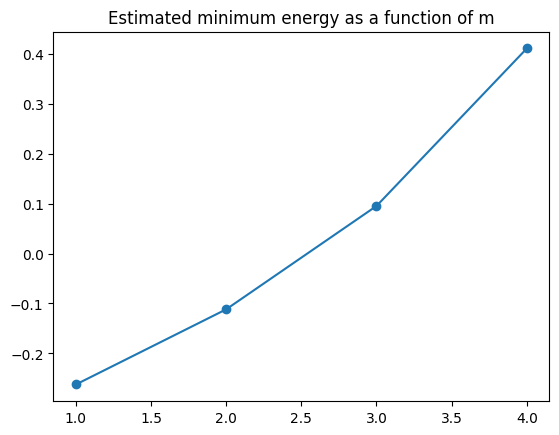

In [ ]:
plt.plot(m_r, energy_min, 'o-')
plt.title("Estimated minimum energy as a function of m")